# Solar Dataset Analysis

In [223]:
# Import Required Libraries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from mlxtend.feature_selection import SequentialFeatureSelector
import plotly.express as px
import plotly.graph_objects as go

## Load and Prepare Data

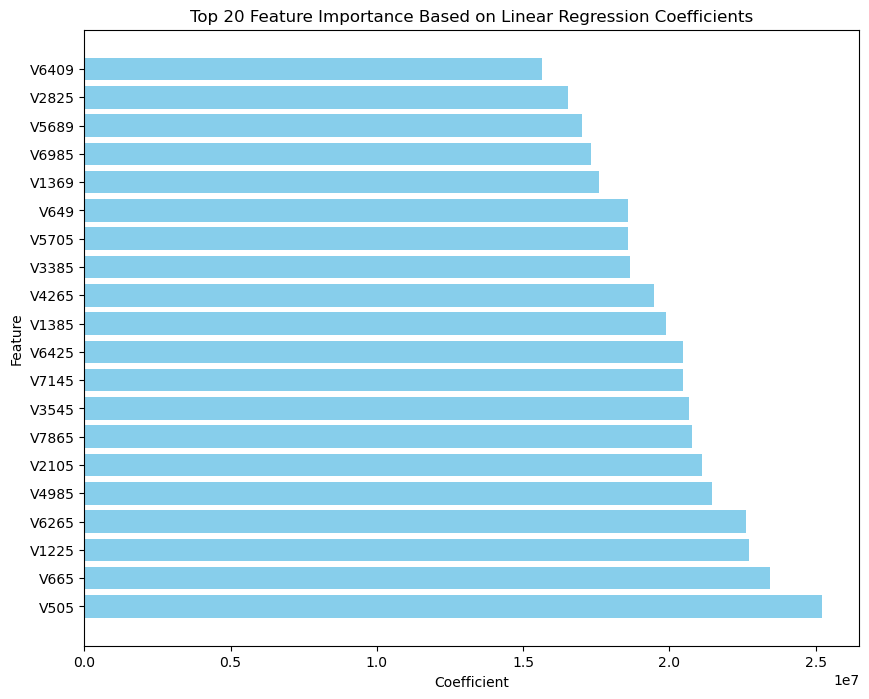

In [ ]:
warnings.filterwarnings("ignore")

# Store the results in a dictionary
results = {'Feature': [], 'Coefficient': [], 'P-Value': []}

# Loop through each PC column to fit a univariate linear regression model
for feature in df_cleaned.drop(columns=["ACME"]).columns:
    X = df_cleaned[feature]  # Feature column
    y = df_cleaned['ACME']   # Target variable (ACME, continuous)

    # Add constant term to the model (intercept)
    X = sm.add_constant(X)
    
    # Fit the linear regression model using OLS
    model = sm.OLS(y, X)
    result = model.fit()
    
    # Store the coefficient and p-value for the feature
    results['Feature'].append(feature)
    results['Coefficient'].append(result.params[1])  # Coefficient for the feature
    results['P-Value'].append(result.pvalues[1])  # P-value for the feature

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort by absolute value of the coefficient to see the most important features
results_df['abs_coefficient'] = results_df['Coefficient'].abs()

# Sort by absolute coefficient to see the most important features
results_df_sorted = results_df.sort_values(by='abs_coefficient', ascending=True)

# Display top 20 features (or adjust the number of top features to show)
top_features = results_df_sorted.head(20)

# Visualize the top feature importance (based on coefficient magnitude)
plt.figure(figsize=(10, 8))  # Increase figure size for better readability
plt.barh(top_features['Feature'], top_features['abs_coefficient'], color='skyblue')
plt.title('Top 20 Feature Importance Based on Linear Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')

# Rotate the feature names for better readability
plt.yticks(rotation=0)

plt.show()

In [205]:
def load_and_merge_datasets(solar_data_path, additional_data_path, preds):
    # Load datasets
    df_solar = pd.read_csv(solar_data_path)
    df_additional = pd.read_csv(additional_data_path)

    # Select columns that start with 'PC' and add 'ACME' and 'Date'
    pc_columns = [col for col in df_solar.columns if col.startswith("PC")]
    # pc_columns.extend(["ACME", "Date", "NINN", "CHIC", "APAC", "KETC"])
    pc_columns.extend(["ACME", "Date"])

    # Create DataFrame with selected columns and merge
    df_pc = df_solar[pc_columns]
    df_merged = pd.merge(df_pc, df_additional, on="Date")
    
    # Convert date format
    df_merged["Date"] = pd.to_datetime(df_merged["Date"], format='%Y%m%d')

    # one hot encoding for months
    df_merged['month'] = df_merged["Date"].dt.month
    month_dummies = pd.get_dummies(df_merged['month'], prefix='month', drop_first=True)
    # Convert the dummy variables to integer type
    month_dummies = month_dummies.astype(int)
    df_merged = pd.concat([df_merged, month_dummies], axis=1)
    df_merged.drop(["Date", 'month'], axis=1, inplace=True)
    

    if preds:
        df_clean = df_merged[df_merged['ACME'].isna()]
    else:
        # Drop rows with NaN in 'ACME'. it messes up the prediction models
        df_clean = df_merged.dropna(subset=['ACME'])
    # Handle missing values in the independent variables by filling with the mode
    df_clean.fillna(df_clean.mode().iloc[0], inplace=True)

    return df_clean

# Load the datasets
df_merged = load_and_merge_datasets("solar_dataset.csv", "additional_variables.csv", False)

## Visualization on a map

In [179]:
station_info = pd.read_csv("station_info.csv")

# Create a scatter plot map with a gradient based on altitude
fig = px.scatter_mapbox(station_info, 
                        lat="nlat", 
                        lon="elon", 
                        color="elev", 
                        size="elev",
                        hover_name="stid",
                        color_continuous_scale=px.colors.sequential.Viridis,  # Gradient from low to high
                        mapbox_style="open-street-map",
                        title="Solar Stations Altitude Gradient")

fig.add_trace(go.Scattermapbox(
    lat=station_info[station_info['stid'] == 'ACME']['nlat'],
    lon=station_info[station_info['stid'] == 'ACME']['elon'],
    mode='markers',
    marker=go.scattermapbox.Marker(size=5000, symbol='star', color='red'),
    name='ACME',
    showlegend=True
))

# Show the figure
fig.show()

## Descriptive Statistics

In [180]:
def display_descriptive_statistics(df):
    # Display descriptive statistics for all columns
    stats = df.describe(include='all')
    print("Descriptive Statistics:\n", stats)

# Show descriptive statistics
display_descriptive_statistics(df_merged)


Descriptive Statistics:
                PC1          PC2          PC3          PC4          PC5  \
count  5113.000000  5113.000000  5113.000000  5113.000000  5113.000000   
mean     -1.727382    -1.875969     3.058668    -1.151610    -1.929864   
std     245.472317    94.313038    76.216318    56.112430    51.235680   
min    -615.810341  -535.511441  -249.364322  -305.063807  -140.280418   
25%    -211.911401   -49.416649   -47.327847   -33.808449   -41.223097   
50%       0.698282    15.387460     5.827901    -2.744266    -6.532958   
75%     233.489345    62.552427    52.079772    30.010729    37.516404   
max     420.287741   238.044178   364.226709   245.850904   225.038318   

               PC6          PC7          PC8          PC9         PC10  ...  \
count  5113.000000  5113.000000  5113.000000  5113.000000  5113.000000  ...   
mean      0.223867     0.524407     0.778260    -0.667953     0.264249  ...   
std      46.371636    41.488266    37.927638    34.548705    29.993790 

## Some fun visualizations

Summary Statistics:
count    5.113000e+03
mean     1.687746e+07
std      7.869606e+06
min      1.200000e+04
25%      1.140420e+07
50%      1.694640e+07
75%      2.373480e+07
max      3.134790e+07
Name: ACME, dtype: float64

Skewness: -0.17197499890810272
Kurtosis: -0.9816462532177823


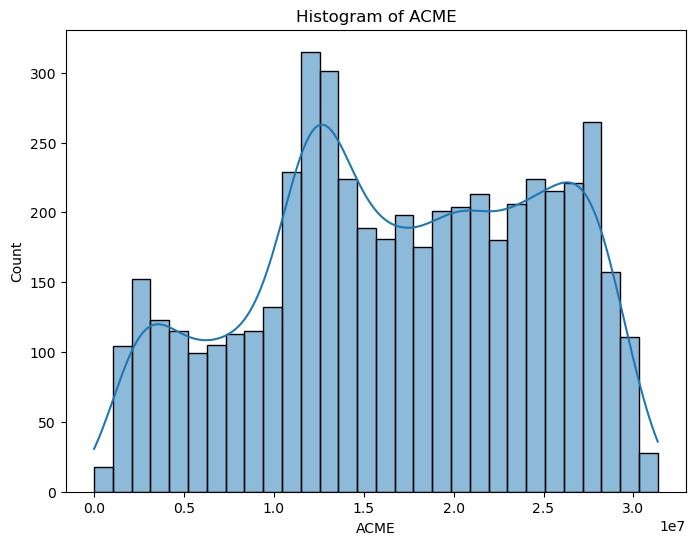

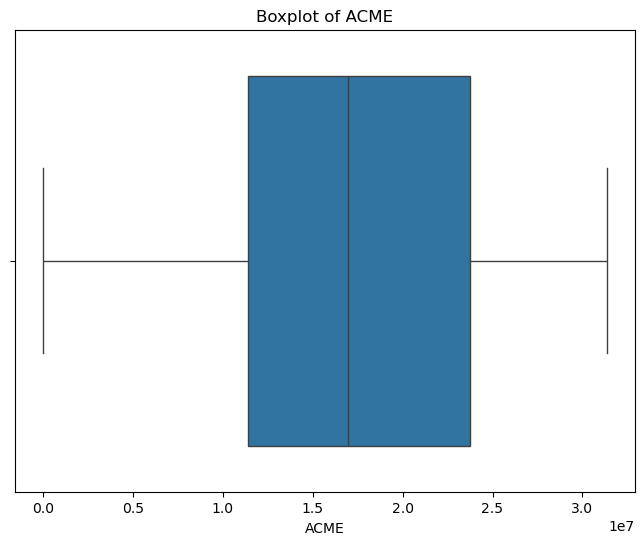

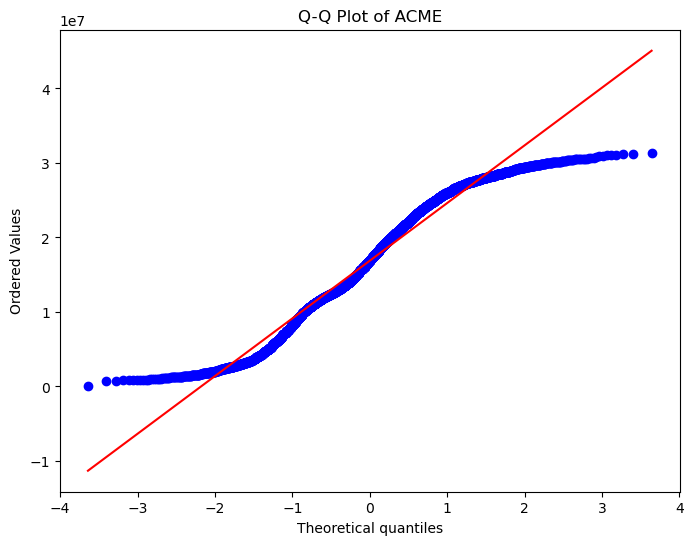

In [181]:
# Merge with additional dataset on 'Date' column
df_merged = load_and_merge_datasets("solar_dataset.csv", "additional_variables.csv")

# Summary Statistics
summary_stats = df_merged["ACME"].describe()
print("Summary Statistics:")
print(summary_stats)

# Skewness and Kurtosis
skewness = df_merged["ACME"].skew()
kurtosis = df_merged["ACME"].kurt()
print(f"\nSkewness: {skewness}")
print(f"Kurtosis: {kurtosis}")

# Visualizing the Distribution - Histogram
plt.figure(figsize=(8, 6))
sns.histplot(df_merged["ACME"], kde=True, bins=30)
plt.title(f'Histogram of {"ACME"}')
plt.show()

# Visualizing the Distribution - Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_merged["ACME"])
plt.title(f'Boxplot of {"ACME"}')
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
plt.figure(figsize=(8, 6))
stats.probplot(df_merged["ACME"], dist="norm", plot=plt)
plt.title(f'Q-Q Plot of {"ACME"}')
plt.show()


## Correlation with 'ACME'

In [183]:
def compute_acme_correlations(df, colname):
    # Compute correlation matrix and extract correlation with 'ACME'
    correlation_matrix = df.corr()

    acme_correlation = correlation_matrix[colname].drop(colname)

    acme_correlation = acme_correlation.abs()
    # Sort the correlation values
    acme_correlation_sorted = pd.DataFrame(acme_correlation.sort_values(ascending=False))
    
    return acme_correlation_sorted
"""
# Calculate and display correlation of all features with 'ACME'
for columni in ["ACME", "NINN", "CHIC", "APAC", "KETC"]:
    acme_correlations = compute_acme_correlations(df_merged, columni)
    print(f"{columni} Correlations:\n", acme_correlations[acme_correlations[columni] > 0.05])
"""

'\n# Calculate and display correlation of all features with \'ACME\'\nfor columni in ["ACME", "NINN", "CHIC", "APAC", "KETC"]:\n    acme_correlations = compute_acme_correlations(df_merged, columni)\n    print(f"{columni} Correlations:\n", acme_correlations[acme_correlations[columni] > 0.05])\n'

In [184]:
df_merged[df_merged.filter(like='V').columns].corr()


,V6409,V3529,V649,V7129,V2089,V1369,V4969,V5689,V7849,V2809,...,V2073,V1785,V1817,V377,V2504,V6137,V6825,V2074,V4697,V3977
V6409,1.000000,0.755204,0.819707,0.752165,0.725470,0.796094,0.699568,0.732923,0.720141,0.756421,...,0.592955,0.413090,0.380151,0.420271,0.493660,0.425499,0.378745,0.408353,0.394481,0.382826
V3529,0.755204,1.000000,0.846279,0.790934,0.781853,0.772273,0.735592,0.743775,0.815807,0.810873,...,0.608191,0.413495,0.350274,0.382128,0.530849,0.379864,0.411366,0.448861,0.372586,0.339429
V649,0.819707,0.846279,1.000000,0.843139,0.836699,0.858592,0.793439,0.844597,0.872865,0.856664,...,0.633817,0.405024,0.365741,0.366949,0.523542,0.383867,0.368117,0.421504,0.368401,0.333080
V7129,0.752165,0.790934,0.843139,1.000000,0.763225,0.792360,0.710430,0.726596,0.770377,0.797638,...,0.574302,0.402578,0.332197,0.358180,0.512798,0.346724,0.393571,0.411557,0.343552,0.335375
V2089,0.725470,0.781853,0.836699,0.763225,1.000000,0.741442,0.758433,0.789838,0.776832,0.770188,...,0.657357,0.405058,0.406562,0.406843,0.506835,0.420333,0.391139,0.421686,0.390946,0.362751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V6137,0.425499,0.379864,0.383867,0.346724,0.420333,0.375338,0.391702,0.385466,0.380886,0.380543,...,0.316592,0.423924,0.862947,0.862930,0.368762,1.000000,0.408099,0.309776,0.784527,0.821752
V6825,0.378745,0.411366,0.368117,0.393571,0.391139,0.405006,0.342676,0.374138,0.373090,0.345293,...,0.406205,0.799619,0.422640,0.459282,0.649451,0.408099,1.000000,0.505578,0.435421,0.449913
V2074,0.408353,0.448861,0.421504,0.411557,0.421686,0.412810,0.419231,0.371900,0.429881,0.413536,...,0.686625,0.534138,0.312998,0.305544,0.410182,0.309776,0.505578,1.000000,0.301823,0.294627
V4697,0.394481,0.372586,0.368401,0.343552,0.390946,0.344960,0.358465,0.335560,0.332457,0.340713,...,0.300731,0.427698,0.813490,0.858644,0.398836,0.784527,0.435421,0.301823,1.000000,0.810143


In [99]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming you have a DataFrame X with features
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data)


      feature        VIF
0         PC1  24.180096
1         PC2  95.201791
2         PC3  22.666446
3         PC4  14.000323
4         PC5  28.736586
..        ...        ...
463   month_8  13.983380
464   month_9   8.469036
465  month_10   7.531186
466  month_11   6.655955
467  month_12   4.271721

[468 rows x 2 columns]


In [102]:
vif_data.sort_values(ascending=False, by="VIF")
vif_data[vif_data["VIF"] > 10]

,feature,VIF
0,PC1,24.180096
1,PC2,95.201791
2,PC3,22.666446
3,PC4,14.000323
4,PC5,28.736586
5,PC6,19.262406
6,PC7,26.196951
7,PC8,19.060029
8,PC9,12.007662
11,PC12,15.030457


## Outlier Detection and Removal

In [210]:
def remove_outliers(df):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=['float'])
    
    # Calculate Q1, Q3, and IQR for numeric columns
    Q1 = numeric_df.quantile(0.1)
    Q3 = numeric_df.quantile(0.9)
    IQR = Q3 - Q1
    
    # Determine the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    df_cleaned = df[~((numeric_df < lower_bound) | (numeric_df > upper_bound)).any(axis=1)]
    
    return df_cleaned

3570

## Standardization of Data

In [186]:
def standardize_data(df):
    scaler = StandardScaler()
    df_scaled = df.copy()
    # Select numerical columns
    numerical_columns = df.select_dtypes(include='float64').columns
    numerical_columns = numerical_columns[numerical_columns != "ACME"]  # Exclude target column
    df_scaled[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    return df_scaled

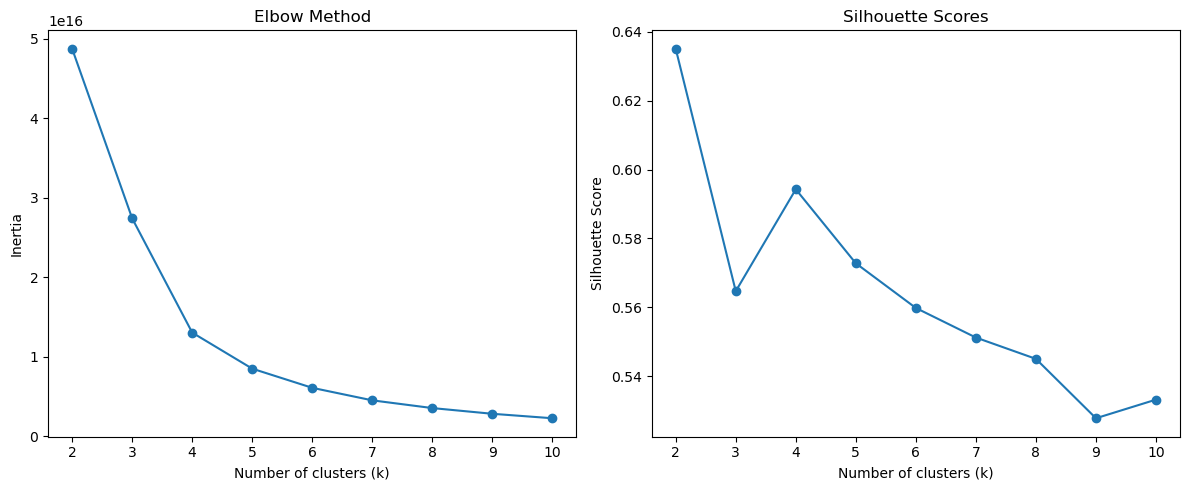

In [187]:
# This is just me playing around, didnt yield anything useful

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Define the range for the number of clusters
k_range = range(2, 11)

inertia = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)  # Set random_state for reproducibility
    kmeans.fit(standardize_data(df_merged))
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(standardize_data(df_merged), kmeans.labels_))

# Plotting Elbow Method
plt.figure(figsize=(12, 5))

# Elbow Plot
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)

# Silhouette Plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)

plt.tight_layout()
plt.show()


## PCA (Principal Component Analysis)

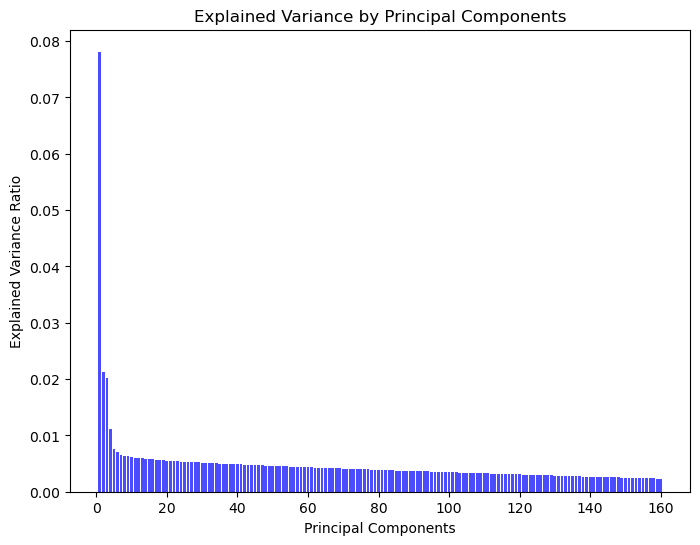

In [219]:
# useless for the moment

def perform_pca(X, n_components):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Plot explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='b')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.show()
    
    return X_pca

# Perform PCA on the scaled data
X_scaled = standardize_data(df_merged).drop(columns=["ACME"])
X_pca = perform_pca(X_scaled, n_components=0.75)

# Feature Selection: 
## K-Best

In [153]:
def select_features_kbest(X, y, k):
    k_best = SelectKBest(score_func=f_regression, k=k)
    X_kbest = k_best.fit_transform(X, y)

    selected_features = X.columns[k_best.get_support()]
    print("Selected Features (KBest):", selected_features.tolist())
    return selected_features

Selected Features (KBest): ['PC1', 'PC2', 'PC5', 'PC7', 'PC10', 'PC12', 'PC17', 'PC19', 'V6409', 'V3529', 'V649', 'V7129', 'V2089', 'V1369', 'V4969', 'V5689', 'V7849', 'V2809', 'V650', 'V7130', 'V2810', 'V4249', 'V3530', 'V6410', 'V2090', 'V7850', 'V360', 'V4250', 'V1801', 'V361', 'V1800', 'V3961', 'V4680', 'V3240', 'V3241', 'V7561', 'V2521', 'V6120', 'V6841', 'V1080', 'V7560', 'V5401', 'V6121', 'V5400', 'V3960', 'V2520', 'V6840', 'V1081', 'V4681', 'V2826', 'V4986', 'V666', 'V6265', 'V3546', 'V5705', 'V2106', 'V4265', 'V7146', 'V665', 'V6426', 'V2825', 'V1385', 'V7145', 'V7866', 'V6425', 'V3545', 'V2105', 'V3385', 'V4985', 'V7834', 'V1353', 'V5706', 'V1386', 'V5674', 'V2505', 'V5673', 'V4266', 'V7865', 'V505', 'V4233', 'V3514', 'V345', 'V1225', 'V2073', 'V1785', 'V1817', 'V377', 'V2504', 'V6137', 'V6825', 'V4697', 'V3977', 'month_2', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_11', 'month_12']


Index(['PC1', 'PC2', 'PC5', 'PC7', 'PC10', 'PC12', 'PC17', 'PC19', 'V6409',
       'V3529', 'V649', 'V7129', 'V2089', 'V1369', 'V4969', 'V5689', 'V7849',
       'V2809', 'V650', 'V7130', 'V2810', 'V4249', 'V3530', 'V6410', 'V2090',
       'V7850', 'V360', 'V4250', 'V1801', 'V361', 'V1800', 'V3961', 'V4680',
       'V3240', 'V3241', 'V7561', 'V2521', 'V6120', 'V6841', 'V1080', 'V7560',
       'V5401', 'V6121', 'V5400', 'V3960', 'V2520', 'V6840', 'V1081', 'V4681',
       'V2826', 'V4986', 'V666', 'V6265', 'V3546', 'V5705', 'V2106', 'V4265',
       'V7146', 'V665', 'V6426', 'V2825', 'V1385', 'V7145', 'V7866', 'V6425',
       'V3545', 'V2105', 'V3385', 'V4985', 'V7834', 'V1353', 'V5706', 'V1386',
       'V5674', 'V2505', 'V5673', 'V4266', 'V7865', 'V505', 'V4233', 'V3514',
       'V345', 'V1225', 'V2073', 'V1785', 'V1817', 'V377', 'V2504', 'V6137',
       'V6825', 'V4697', 'V3977', 'month_2', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_11', 'month_12'],
      dtype

## Elastic Net

In [190]:

from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

def elastic_net_feature_selection_with_cv(X, y):
    # Create a range of alpha values and l1_ratio values
    alphas = np.logspace(-5, 5, 100)
    l1_ratios = np.linspace(0, 1, 10)  # L1 ratio from 0 (Ridge) to 1 (Lasso)

    # Create and fit ElasticNetCV
    elastic_net_cv = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)
    elastic_net_cv.fit(X, y)

    # Best parameters
    best_alpha = elastic_net_cv.alpha_
    best_l1_ratio = elastic_net_cv.l1_ratio_

    # Fit the Elastic Net model with the best parameters
    elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
    elastic_net.fit(X, y)

    # Get the coefficients and select features
    elastic_net_coefficients = pd.Series(elastic_net.coef_, index=X.columns)
    selected_features = elastic_net_coefficients[elastic_net_coefficients.abs() > 0.05].index.tolist()

    return selected_features


# Models for generating predictions
## Random Forest, Gradient Boosting, Neural Network Models

In [197]:
def train_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    importances = model.feature_importances_
    return pd.DataFrame(y_pred)

In [224]:
# Function to build and compile a neural network
def build_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Assuming regression output
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [225]:
# Load the training data (cleaning and scaling are not mandatory)
df_merged = load_and_merge_datasets("solar_dataset.csv", "additional_variables.csv", False)
df_cleaned = remove_outliers(df_merged)
df_scaled = standardize_data(df_cleaned)

# Load the testing data
df_test = load_and_merge_datasets("solar_dataset.csv", "additional_variables.csv", True)
df_test_scaled = standardize_data(df_test)


In [226]:
# Here we can choose what data we train on in the creation of the model
# Split dataset for training
X_train = df_scaled.drop(columns=["ACME"])
y_train = df_scaled["ACME"]

In [227]:
# X_test always stays the same
X_test = df_test_scaled.drop(columns=["ACME"])
# y test empty cos we are scoring on kaggle, we dont have the acual values to compare
y_test = pd.DataFrame()

In [230]:
# Here we have to select which way we are going to select features that we use in the training and predictions
# Elastic Net
# selected_features = elastic_net_feature_selection_with_cv(X_train, y_train)

# K best
# selected_features = select_features_kbest(X_train, y_train, k=100)

# All 
selected_features = df_scaled.drop(columns=["ACME"]).columns

In [231]:
# List of models you want to train
models = {
    "Random_Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient_Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Neural_Network": None  # Placeholder for the NN model
}

# Read the sample submission file
submission = pd.read_csv("sampleSubmission.csv")

# Iterate over each model in the list
for model_name in models.keys():
    if model_name == "Neural_Network":
        # Build and train the neural network
        nn_model = build_nn_model(X_train[selected_features].shape[1])
        nn_model.fit(X_train[selected_features], y_train, epochs=100, batch_size=32, verbose=0)
        result = nn_model.predict(X_test[selected_features]).flatten()  # Flatten the output
    else:
        # Train and evaluate the other models
        model = models[model_name]
        result = train_model(model, X_train[selected_features], y_train, X_test[selected_features], y_test)

    # Create a copy of the submission DataFrame for the current model
    model_submission = submission.copy()
    
    # Add predictions to the new DataFrame
    model_submission["ACME"] = result
    
    # Save the predictions to a CSV file
    model_submission.to_csv(f"{model_name}.csv", index=False)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
